Detection of sarcasm in sentences - 
In this notebook, we have tried 3 methods for detecting sarcasm in sentences - 
1. Basic Linear Regression
2. Bidirectional LSTM
3. Attention-Like Classifier

We have tried these methods on "News Headlines Dataset For Sarcasm Detection" in Kaggle. We have reached 87% accuracy in the third method.



In [1]:
## Imports ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
import copy
import multiprocessing as mp
num_procs =  mp.cpu_count()
from multiprocessing import Pool


import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR

import nltk
from nltk import pos_tag, word_tokenize
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

from sklearn import metrics
from sklearn.metrics import auc, roc_curve

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Asaf Karnieli\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to C:\Users\Asaf
[nltk_data]     Karnieli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import gensim.downloader as api
model_types = ["glove-wiki-gigaword-100"] #"glove-twitter-100", "glove-wiki-gigaword-100", "glove-wiki-gigaword-300"] ### FIXME!!
word2vec_model_dict = {}

for model_type in model_types:
    word2vec_model_dict[model_type] = api.load(model_type)
    

C:\Users\Asaf Karnieli\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Asaf Karnieli\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [3]:
# data_url = "https://raw.githubusercontent.com/asafkar/sarcarsm_detection/master/Sarcasm_Headlines_Dataset_v2.json"

data_url = os.path.join(os.getcwd(),"Sarcasm_Headlines_Dataset_v2.json")

# Read the Data, remove "article_link", and display properties
df = pd.read_json(open(data_url, "r", encoding="utf8"), lines=True)
df = df[['headline','is_sarcastic']]
df['headline'] = df['headline'].apply(lambda x: x.lower())
df['headline'] = df['headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df.describe()


,is_sarcastic
count,28619.000000
mean,0.476397
std,0.499451
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [4]:
# go over the data. 
# data_padded is the data padded, in order to receive fixed length sentences

def second_longest_sentence():
    longest_sentence = 0
    second_longest = 0
    for sents in df['headline'].values:
        if len(sents.split()) > longest_sentence:
            second_longest = longest_sentence
            longest_sentence = len(sents.split())
    return second_longest

model_sentence_length = second_longest_sentence()

def word2vec(word, word_embedding_model):
    try:
        return word_embedding_model[word]
    except:
        return word_embedding_model['unk']

    
def sentence2vecs(sentence, word_embedding_model):
    return [word2vec(x, word_embedding_model) for x in sentence.split()]


# function to encode ntlk POS tags. 0 is none
def tag_to_num(tag):
    pos_tags_list = ['CC', 'CD', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS','NNP', \
                  'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', \
                  'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'] 
    len_ = len(pos_tags_list)
    mean_ = np.mean(np.arange(len_) )
    std_ =  np.std(np.arange(len_) )
    
    if tag in pos_tags_list:
        tag_emb =  (pos_tags_list.index(tag)+1)
        return (tag_emb - mean_)/(2*std_)  # zero mean and std=1
    else:
        return 0

   
    
# word2vec - For each sample (sentence), turn each word into a word-embedding
corpus_size = df['headline'].size

# generate data according to word2vec module
def gen_data(word_embedding_model, gen_pos_data=False):
    word2vec_model_size = len(word_embedding_model['unk'])
    
    if gen_pos_data:
        data_padded = np.zeros((corpus_size, model_sentence_length , word2vec_model_size+1))
    else:
        data_padded = np.zeros((corpus_size, model_sentence_length , word2vec_model_size))
        
    data = []
    labels = np.zeros(corpus_size, dtype=np.int)
    
    indices = np.arange(corpus_size)
    
    for ii in range(df.shape[0]):
        sents = df['headline'].iloc[ii]
        tok_sents = word_tokenize(sents)
#         temp_sents = []
        labels[ii]= df['is_sarcastic'].iloc[ii]

        vectors = sentence2vecs(sents, word_embedding_model)  # size = word2vec_model_size*sentence_length
        data.append(vectors)
        for jj, vector in enumerate(vectors):
            if jj == model_sentence_length:
                break
            vec = np.asarray(vector)
            if gen_pos_data:
                
                # [0][1] since this is the format - [('scientists', 'NNS')]
                vec = np.hstack((vec, tag_to_num(pos_tag([tok_sents[jj]])[0][1]))) 
#                 print((tok_sents[jj]))
#                 print(tag_to_num(pos_tag([tok_sents[jj]])[0][1])) 
            data_padded[ii, jj,:] = vec
    
    
    # Split to Train and Test (For both padded and unpadded)
    training_samples  = corpus_size*8//10
    validation_samples = (corpus_size - training_samples)//2
    test_samples = (corpus_size - training_samples)//2

    np.random.shuffle(indices)
    data_padded = data_padded[indices]
    
   
    labels = labels[indices]
    X_train = data_padded[:training_samples]
    y_train = labels[:training_samples]

    X_val = data_padded[training_samples: training_samples + validation_samples]
    y_val = labels[training_samples: training_samples + validation_samples]

    X_test = data_padded[training_samples+validation_samples: training_samples + validation_samples+test_samples]
    y_test = labels[training_samples+validation_samples: training_samples      + validation_samples+test_samples]
    
    return X_train, y_train, X_val, y_val, X_test, y_test  #, X_train_raw, X_val_raw, X_test_raw
        

## Run the following cell once for every word2vec model you wish to try

In [5]:

# model_types are ["glove-twitter-100", "glove-wiki-gigaword-100", "glove-wiki-gigaword-300"]
curr_word2vec_model = word2vec_model_dict["glove-wiki-gigaword-100"]
word2vec_model_size = len(curr_word2vec_model['unk'])
X_train, y_train, X_val, y_val, X_test, y_test  = gen_data(curr_word2vec_model)


*First Attempt - Linear Regression*

In [6]:

from sklearn.linear_model import LogisticRegression
X_train_flat = X_train.reshape(-1, model_sentence_length*(word2vec_model_size))
X_val_flat = X_val.reshape(-1, model_sentence_length*(word2vec_model_size))
X_test_flat = X_test.reshape(-1, model_sentence_length*(word2vec_model_size))
log_reg = LogisticRegression()
log_reg.fit(X_train_flat, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(log_reg.score(X_train_flat, y_train)))
print('Accuracy of Logistic regression classifier  on test set: {:.2f}'
     .format(log_reg.score(X_val_flat, y_val)))

y_LR_test = log_reg.predict(X_test_flat)

C:\Users\Asaf Karnieli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of Logistic regression classifier on training set: 0.82
Accuracy of Logistic regression classifier  on test set: 0.78


In [97]:
# function for training the model and retuning the trained model object

def train_model(model, criterion, num_epochs, data_loader, optimizer, input_sz):
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0
    
#     total_step = len(train_loader)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    
    for epoch in range(num_epochs):
        print('-*' * 10)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode        

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions    
            running_total = 0
            
            
            for i, (sents, labels) in enumerate(data_loader[phase]):
                sents = sents.reshape(-1, sequence_length, input_sz).to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    # Forward pass
                    outputs = model(sents)
                    _, predicted = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # Backward and optimize when training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item()
                running_corrects += (predicted == labels).sum().item() 
                running_total += labels.size(0)

            if (phase == 'train'):
                model.train_acc.append(running_corrects / running_total)
                model.train_loss.append(running_loss / running_total)
            else:
                model.val_acc.append(running_corrects / running_total)
                model.val_loss.append(running_loss / running_total)

            epoch_loss = loss.item() 
            epoch_acc = running_corrects / running_total
            scheduler.step()
            print('{} Loss: {:.4f}  |  Acc: {:.4f} '.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model if better results were acquired
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    model.epochs_used = num_epochs
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def plot_graphs(best_model):
    plt.figure(figsize=(6, 12))

    plt.subplot(311)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,best_model.epochs_used+1),best_model.train_acc,label="Train")
    plt.plot(range(1,best_model.epochs_used+1),best_model.val_acc,label="Validate")
    plt.xticks(np.arange(1, best_model.epochs_used+1, 1.0))
    plt.legend()

    plt.subplot(312)
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Epoch average)")
    plt.plot(range(1,best_model.epochs_used+1),best_model.train_loss,label="Train")
    plt.plot(range(1,best_model.epochs_used+1),best_model.val_loss,label="Validate")
    plt.xticks(np.arange(1, best_model.epochs_used+1, 1.0))
    plt.legend()

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

*Second Attempt - Bidirectional LSTM*

In [9]:
# CPU or GPU :
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = model_sentence_length
input_size =      word2vec_model_size
hidden_size = 128
num_layers = 2
num_classes = 2
batch_size = 64
num_epochs = 8
learning_rate = 0.005
lstm_dropout = 0.1


# Data loader
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
val_loader =  torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

data_loader = {"train" : train_loader, "test" : test_loader, "val" : val_loader}
              

In [10]:
# Base model - 
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        # Store best model history
        self.epochs_used = 0
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []       
        self.train_iou =[]
        self.val_iou = []
        self.avg_loss_l = []
        avg_accuracy_l = []

In [11]:

# Bidirectional LSTM (many to one)
class BiLSTM(BaseModel):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, lstm_dropout):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, 2)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

lstm_model = BiLSTM(input_size, hidden_size, num_layers, num_classes, lstm_dropout).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
    


In [12]:
best_lstm_model = train_model(lstm_model, criterion, num_epochs, data_loader, optimizer, input_size)
 

-*-*-*-*-*-*-*-*-*-*
Epoch 1/8
train Loss: 0.6822  |  Acc: 0.5310 
val Loss: 0.7137  |  Acc: 0.5143 
-*-*-*-*-*-*-*-*-*-*
Epoch 2/8
train Loss: 0.4197  |  Acc: 0.6479 
val Loss: 0.3508  |  Acc: 0.8249 
-*-*-*-*-*-*-*-*-*-*
Epoch 3/8
train Loss: 0.3477  |  Acc: 0.8388 
val Loss: 0.4378  |  Acc: 0.8291 
-*-*-*-*-*-*-*-*-*-*
Epoch 4/8
train Loss: 0.3570  |  Acc: 0.8555 
val Loss: 0.3986  |  Acc: 0.8351 
-*-*-*-*-*-*-*-*-*-*
Epoch 5/8
train Loss: 0.3564  |  Acc: 0.8581 
val Loss: 0.3996  |  Acc: 0.8361 
-*-*-*-*-*-*-*-*-*-*
Epoch 6/8
train Loss: 0.3556  |  Acc: 0.8595 
val Loss: 0.4004  |  Acc: 0.8361 
-*-*-*-*-*-*-*-*-*-*
Epoch 7/8
train Loss: 0.3556  |  Acc: 0.8598 
val Loss: 0.4004  |  Acc: 0.8361 
-*-*-*-*-*-*-*-*-*-*
Epoch 8/8
train Loss: 0.3556  |  Acc: 0.8597 
val Loss: 0.4004  |  Acc: 0.8361 


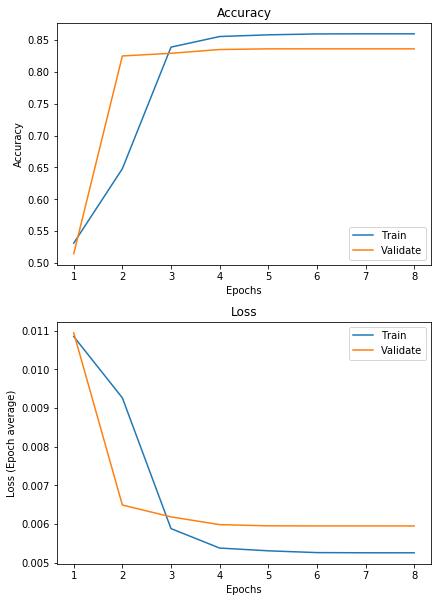

In [13]:
plot_graphs(best_lstm_model)

*Third Attempt - Attention*

In [82]:
# CPU or GPU :
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = model_sentence_length 
input_size =      word2vec_model_size   # embedding size
hidden_size = input_size    # 128  # should be according to input_size? 
num_layers = 2
num_classes = 2
batch_size = 64
num_epochs = 8
learning_rate = 0.005
lstm_dropout = 0.1  # dropout between 2 lstm layers
alpha_dropout = 0.3 # dropout between attention output and fc



Ideas are from the following paper - *Attention-Based Bidirectional Long Short-Term Memory Networks for
Relation Classification*
https://www.aclweb.org/anthology/P16-2034

In [83]:
# Attention Like Model 
class AttentionModel(BaseModel):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, lstm_dropout, sequence_length, alpha_dropout):
        super(AttentionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=lstm_dropout)
        
#         self.alpha_net = nn.Linear(hidden_size*2*sequence_length, sequence_length)
        self.alpha_net = nn.Linear(hidden_size*2, 1)
    
        self.dropout = nn.Dropout(alpha_dropout)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
        self.input_size = input_size
        
    def attention_layer(self, input_from_lstm):
        # H = {h1,h2...,ht} = input_from_lstm
        # alpha = softmax(w*M)
        M = nn.Tanh()(input_from_lstm).permute(1,0,2) # torch.Size([64, 29, 256]) - batch, sequence_length, hidden*2
        
#         print("M shape = {}".format(M.shape))
#         print(input_size)
        M = M.contiguous().view((-1, 2*self.input_size))
#         print(M.shape)
        wM = self.alpha_net(M)
#         print(wM.shape)
        wM = wM.view((-1, sequence_length, 1)).squeeze()
#         print(wM.shape)
        
        alpha_weights = F.softmax(wM, 1).unsqueeze(2) # includes w (weights) - sized hidden*2 - unsqueeze to add axis for bmm
        
        # r = H*alpha
        #  bmm shape should be (b×n×m) and (b×m×p) then only it will give (b×n×p) as the output shape
        r = torch.bmm(input_from_lstm.permute(1,2,0), alpha_weights).squeeze()
        return r        
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # lstm_out: tensor of shape (batch_size, seq_length, hidden_size*2) - 
        # tensor containing the output features (h_t) from the last layer of the LSTM, for each t
        
        # last_hidden_state : (num_layers*2, batch_size, hidden_size) -
        #  tensor containing the hidden state for t = seq_len ; used for backprop...
        lstm_out, (last_hidden_state, last_cell_state) = self.lstm(x, (h0, c0)) 
        
        attention_out = self.attention_layer(lstm_out.permute(1,0,2))
        h_star = nn.Tanh()(attention_out)
        out = self.fc(self.dropout((h_star)))
        return out

att_model = AttentionModel(input_size, hidden_size, num_layers, num_classes, lstm_dropout, 
                       sequence_length, alpha_dropout).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(att_model.parameters(), lr=learning_rate, weight_decay=0.0001)
    



In [84]:
# Train the model
best_att_model = train_model(att_model, criterion, num_epochs, data_loader, optimizer, input_size)



-*-*-*-*-*-*-*-*-*-*
Epoch 1/8
train Loss: 0.5026  |  Acc: 0.7596 
val Loss: 0.3094  |  Acc: 0.8431 
-*-*-*-*-*-*-*-*-*-*
Epoch 2/8
train Loss: 0.4125  |  Acc: 0.8453 
val Loss: 0.2837  |  Acc: 0.8571 
-*-*-*-*-*-*-*-*-*-*
Epoch 3/8
train Loss: 0.3166  |  Acc: 0.8842 
val Loss: 0.2500  |  Acc: 0.8665 
-*-*-*-*-*-*-*-*-*-*
Epoch 4/8
train Loss: 0.3269  |  Acc: 0.8971 
val Loss: 0.2396  |  Acc: 0.8669 
-*-*-*-*-*-*-*-*-*-*
Epoch 5/8
train Loss: 0.3223  |  Acc: 0.8979 
val Loss: 0.2387  |  Acc: 0.8662 
-*-*-*-*-*-*-*-*-*-*
Epoch 6/8
train Loss: 0.3324  |  Acc: 0.9010 
val Loss: 0.2388  |  Acc: 0.8658 
-*-*-*-*-*-*-*-*-*-*
Epoch 7/8
train Loss: 0.2937  |  Acc: 0.9018 
val Loss: 0.2388  |  Acc: 0.8658 
-*-*-*-*-*-*-*-*-*-*
Epoch 8/8
train Loss: 0.3422  |  Acc: 0.9003 
val Loss: 0.2388  |  Acc: 0.8658 


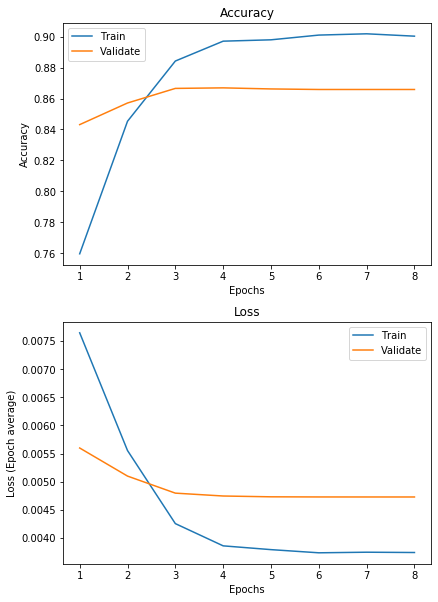

In [89]:
plot_graphs(best_att_model)

# 4th attempt - BiLSTM + Attention-like, with POS tagging information and deeper network


In [94]:
# CPU or GPU :
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = model_sentence_length
input_size_pos =      word2vec_model_size + 1  # embedding size
hidden_size_pos = input_size_pos  # 128  # should be according to input_size? 
num_layers = 2
num_classes = 2
batch_size = 64
num_epochs = 8
learning_rate = 0.005
lstm_dropout = 0.3  # dropout between 2 lstm layers
alpha_dropout = 0.3 # dropout between attention output and fc





In [95]:
# Attention Like Model 
class SarcasmNet(BaseModel):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, lstm_dropout, sequence_length, alpha_dropout):
        super(SarcasmNet, self).__init__()
#         print(input_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=lstm_dropout)
        
#         self.alpha_net = nn.Linear(hidden_size*2*sequence_length, sequence_length)
        self.alpha_net_1 = nn.Linear(input_size*2 + hidden_size , hidden_size)
        self.alpha_net_2 = nn.Linear(hidden_size , 1)
    
        self.dropout = nn.Dropout(alpha_dropout)
        self.dropout2 = nn.Dropout(alpha_dropout)
        self.dropout3 = nn.Dropout(alpha_dropout)
        
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
        self.w = torch.nn.Parameter(data=torch.Tensor(2*hidden_size), requires_grad=True)
        
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        
    def attention_layer(self, input_from_lstm, x):
        # H = {h1,h2...,ht} = input_from_lstm
        # alpha = softmax(w*M)
        M = nn.Tanh()(input_from_lstm).permute(1,0,2) # torch.Size([64, 29, 202]) - batch, sequence_length, hidden*2
        
        
#         print("M shape = {}".format(M.shape))
#         print("x shape = {}".format(x.shape))
        
        M_ = torch.cat((M, x), 2)
#         print("M_ shape = {}".format(M_.shape))
        M_ = M_.contiguous().view((-1, (2*self.hidden_size + self.input_size)))
#         print("M after view shape = {}".format(M.shape))
        wM = nn.Tanh()(self.bn1(self.alpha_net_1(M_)))
        wM = self.alpha_net_2(wM)
        
#         print("wM shape = {}".format(wM.shape))
        wM = wM.view((-1, sequence_length, 1)).squeeze()
        
        alpha_weights = F.softmax(wM, 1).unsqueeze(2) # includes w (weights) - sized hidden*2 - unsqueeze to add axis for bmm
        
        # r = H*alpha
        #  bmm shape should be (b×n×m) and (b×m×p) then only it will give (b×n×p) as the output shape
        r = torch.bmm(input_from_lstm.permute(1,2,0), alpha_weights).squeeze()
        return r        
    
    def forward(self, x):
        # Set initial states
        
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # lstm_out: tensor of shape (batch_size, seq_length, hidden_size*2) - 
        # tensor containing the output features (h_t) from the last layer of the LSTM, for each t
        
        # last_hidden_state : (num_layers*2, batch_size, hidden_size) -
        #  tensor containing the hidden state for t = seq_len ; used for backprop...
        lstm_out, (last_hidden_state, last_cell_state) = self.lstm(x, (h0, c0)) 
        
        lstm_out = self.dropout3(lstm_out)
        
        attention_out = self.attention_layer(lstm_out.permute(1,0,2), x)
        h_star = self.dropout2(nn.Tanh()(attention_out))
        out = self.fc(self.dropout((h_star)))
        return out

sarcarsm_model = SarcasmNet(input_size_pos, hidden_size_pos, num_layers, num_classes, lstm_dropout, 
                       sequence_length, alpha_dropout).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sarcarsm_model.parameters(), lr=learning_rate, weight_decay=0.00001)
    


In [92]:
## Create data with POS tagging -

X_train_pos, y_train_pos, X_val_pos, y_val_pos, X_test_pos, y_test_pos  = gen_data(curr_word2vec_model, True)

# X_train_pos, X_val_pos, X_test_pos = X_train_pos[:,:,:-1], X_val_pos[:,:,:-1], X_test_pos[:,:,:-1]


pos_train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train_pos).float(), torch.from_numpy(y_train_pos).long())
pos_train_loader =  torch.utils.data.DataLoader(pos_train_dataset, batch_size=batch_size, shuffle=False)

pos_test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test_pos).float(), torch.from_numpy(y_test_pos).long())
pos_test_loader =  torch.utils.data.DataLoader(pos_test_dataset, batch_size=batch_size, shuffle=False)

pos_val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val_pos).float(), torch.from_numpy(y_val_pos).long())
pos_val_loader =  torch.utils.data.DataLoader(pos_val_dataset, batch_size=batch_size, shuffle=False)

pos_data_loader = {"train" : pos_train_loader, "test" : pos_test_loader, "val" : pos_val_loader}

In [98]:
# Train the model
best_sarcasm_model = train_model(sarcarsm_model, criterion, num_epochs, pos_data_loader, optimizer, input_size_pos)

-*-*-*-*-*-*-*-*-*-*
Epoch 1/8
train Loss: 0.3033  |  Acc: 0.7687 
val Loss: 0.3607  |  Acc: 0.8459 
-*-*-*-*-*-*-*-*-*-*
Epoch 2/8
train Loss: 0.2189  |  Acc: 0.8582 
val Loss: 0.2340  |  Acc: 0.8557 
-*-*-*-*-*-*-*-*-*-*
Epoch 3/8
train Loss: 0.2052  |  Acc: 0.9045 
val Loss: 0.1753  |  Acc: 0.8686 
-*-*-*-*-*-*-*-*-*-*
Epoch 4/8
train Loss: 0.1835  |  Acc: 0.9174 
val Loss: 0.1743  |  Acc: 0.8700 
-*-*-*-*-*-*-*-*-*-*
Epoch 5/8
train Loss: 0.1889  |  Acc: 0.9184 
val Loss: 0.1729  |  Acc: 0.8704 
-*-*-*-*-*-*-*-*-*-*
Epoch 6/8
train Loss: 0.1813  |  Acc: 0.9209 
val Loss: 0.1725  |  Acc: 0.8704 
-*-*-*-*-*-*-*-*-*-*
Epoch 7/8
train Loss: 0.1886  |  Acc: 0.9209 
val Loss: 0.1725  |  Acc: 0.8704 
-*-*-*-*-*-*-*-*-*-*
Epoch 8/8
train Loss: 0.2147  |  Acc: 0.9206 
val Loss: 0.1725  |  Acc: 0.8704 


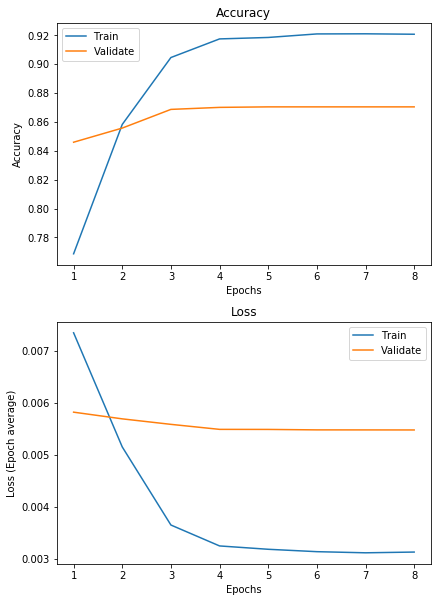

In [100]:
plot_graphs(best_sarcasm_model)

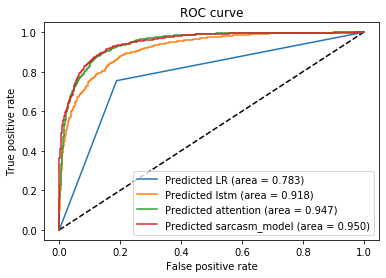

In [99]:
# example from here - https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

# 1 - LR results
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_LR_test)
auc_LR = metrics.auc(fpr_LR, tpr_LR) # area under curve


# 2 - LSTM model 
res_lstm = best_lstm_model(torch.from_numpy(X_test).float().to(device)).to('cpu').detach().numpy()
y_test_lstm = res_lstm[:, 1]

fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_test_lstm)
auc_lstm = metrics.auc(fpr_lstm, tpr_lstm) # area under curve


# 3 - attention model
res_att = best_att_model(torch.from_numpy(X_test).float().to(device)).to('cpu').detach().numpy()
y_test_att = res_att[:, 1]

fpr_att, tpr_att, thresholds_att = roc_curve(y_test, y_test_att)
auc_att = metrics.auc(fpr_att, tpr_att) # area under curve


# 4 - Final model 
res_pos = best_sarcasm_model(torch.from_numpy(X_test_pos).float().to(device)).to('cpu').detach().numpy()
y_test_sarcasm = res_pos[:, 1]

fpr_sarcasm_model, tpr_sarcasm_model, thresholds_sarcasm_model = roc_curve(y_test_pos, y_test_sarcasm)
auc_sarcasm_model = metrics.auc(fpr_sarcasm_model, tpr_sarcasm_model) # area under curve


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_LR, tpr_LR, label='Predicted LR (area = {:.3f})'.format(auc_LR))
plt.plot(fpr_lstm, tpr_lstm, label='Predicted lstm (area = {:.3f})'.format(auc_lstm))
plt.plot(fpr_att, tpr_att, label='Predicted attention (area = {:.3f})'.format(auc_att))
plt.plot(fpr_sarcasm_model, tpr_sarcasm_model, label='Predicted sarcasm_model (area = {:.3f})'.format(auc_sarcasm_model))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
